In [30]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import linregress
from sparse_ffn.moe import MoE
from sparse_ffn.controller import ControllerFFN
from sparse_ffn.pkm import PKM

In [31]:
def name_conversion(name):
    arch = "GPT-Neo" if 'gpt' in name else "RoBERTa"
    if 'baseline' in name:
        return f"{arch}"
    if 'moe' in name:
        sparsity_type = 'MoE'
        if 'low' in name:
            sparsity_level = '($k=3$)'
        elif 'medium' in name:
            sparsity_level = '($k=2$)'
        else:
            sparsity_level = '($k=1$)'
            
    elif 'cnt' in name:
        sparsity_type = 'CNT'
        if 'low' in name:
            sparsity_level = '($N=64$)'
        elif 'medium' in name:
            sparsity_level = '($N=32$)'
        else:
            sparsity_level = '($N=16$)'
    elif 'pkm' in name:
        sparsity_type = 'PKM'
        if 'low' in name:
            sparsity_level = '($k=42$)'
        elif 'medium' in name:
            sparsity_level = '($k=28$)'
        else:
            sparsity_level = '($k=14$)'
    return f"{arch} {sparsity_type} {sparsity_level}"

In [32]:
def blimp_results(model_name, model_path):
    results = {'Name':None, 'Overall': None}
    correct = 0
    total = 0
    results_dir = os.path.join(model_path, 'zeroshot/')
    for subdir in os.listdir(results_dir):
        task_name = subdir.replace('_', ' ').title()
        task_dir = os.path.join(results_dir, subdir)
        pred_path = os.path.join(task_dir,'predictions.txt')
        num_pred = len(pd.read_csv(pred_path, sep="\t", header=0, index_col=0))
        eval_results_path = os.path.join(task_dir, 'eval_results.json')
        with open(eval_results_path, 'r') as json_file:
            data = json.load(json_file)
            eval_accuracy = data.get('eval_accuracy')
            results[task_name] = [eval_accuracy]
            total += num_pred
            correct += num_pred * eval_accuracy
    results["Name"] = [model_name]
    results["Overall"] = [correct/total]
    df = pd.DataFrame(results)
    return df

In [33]:
def blimp_results_all(path):
    dfs = []
    for subdir in os.listdir(path):
        dfs.append(blimp_results(name_conversion(subdir), os.path.join(path, subdir)))
    return pd.concat(dfs, ignore_index=True)

In [34]:
table = blimp_results_all('../../models/sparse_pretrained/')
table

,Name,Overall,Anaphor Agreement,Argument Structure,Binding,Control Raising,Determiner Noun Agreement,Ellipsis,Filler Gap,Hypernym,Irregular Forms,Island Effects,Npi Licensing,Qa Congruence Easy,Qa Congruence Tricky,Quantifiers,Subject Aux Inversion,Subject Verb Agreement,Turn Taking
0,GPT-Neo,0.588985,0.818507,0.602449,0.655091,0.581529,0.626757,0.529446,0.570339,0.490698,0.662595,0.426756,0.440024,0.546875,0.393939,0.660484,0.730910,0.499548,0.560714
1,GPT-Neo CNT ($N=16$),0.544106,0.728016,0.575291,0.590828,0.606054,0.580085,0.431293,0.608310,0.515116,0.551145,0.484305,0.397206,0.484375,0.436364,0.381504,0.618931,0.501716,0.610714
2,GPT-Neo CNT ($N=64$),0.538353,0.763804,0.547527,0.638172,0.583297,0.568019,0.471709,0.591503,0.519767,0.527735,0.423393,0.295627,0.406250,0.448485,0.504122,0.636253,0.511472,0.553571
3,GPT-Neo CNT ($N=32$),0.588685,0.784765,0.583778,0.651677,0.575122,0.600504,0.431293,0.626050,0.511628,0.598473,0.455904,0.488916,0.468750,0.454545,0.691139,0.700659,0.495935,0.528571
4,GPT-Neo MoE ($k=1$),0.530768,0.726994,0.539161,0.565895,0.585064,0.544285,0.455543,0.563648,0.512791,0.537405,0.413303,0.379897,0.546875,0.406061,0.517517,0.655038,0.489431,0.467857
5,GPT-Neo MoE ($k=3$),0.567430,0.634969,0.574564,0.616503,0.585506,0.582604,0.479215,0.617025,0.501163,0.598982,0.423019,0.433799,0.500000,0.393939,0.682895,0.642596,0.503523,0.596429
6,GPT-Neo MoE ($k=2$),0.552355,0.707055,0.543889,0.595132,0.599867,0.547335,0.409931,0.575475,0.488372,0.537405,0.467115,0.473884,0.406250,0.387879,0.624678,0.628202,0.493586,0.550000
7,GPT-Neo PKM ($k=14$),0.569912,0.780164,0.559893,0.643218,0.602519,0.574516,0.466513,0.593838,0.490698,0.590840,0.482810,0.444428,0.515625,0.387879,0.636012,0.619175,0.515266,0.514286
8,GPT-Neo PKM ($k=42$),0.552149,0.758180,0.571048,0.587266,0.600530,0.575179,0.393187,0.592437,0.488372,0.600000,0.462631,0.352111,0.421875,0.466667,0.611283,0.623567,0.523758,0.564286
9,GPT-Neo PKM ($k=28$),0.583929,0.796012,0.587294,0.605818,0.597879,0.600239,0.392610,0.626517,0.458140,0.652417,0.473468,0.434254,0.500000,0.503030,0.690366,0.715052,0.512195,0.589286


In [35]:
print(table.to_latex(index=False,float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrrrrrrrr}
\toprule
Name & Overall & Anaphor Agreement & Argument Structure & Binding & Control Raising & Determiner Noun Agreement & Ellipsis & Filler Gap & Hypernym & Irregular Forms & Island Effects & Npi Licensing & Qa Congruence Easy & Qa Congruence Tricky & Quantifiers & Subject Aux Inversion & Subject Verb Agreement & Turn Taking \\
\midrule
GPT-Neo & 0.589 & 0.819 & 0.602 & 0.655 & 0.582 & 0.627 & 0.529 & 0.570 & 0.491 & 0.663 & 0.427 & 0.440 & 0.547 & 0.394 & 0.660 & 0.731 & 0.500 & 0.561 \\
GPT-Neo CNT ($N=16$) & 0.544 & 0.728 & 0.575 & 0.591 & 0.606 & 0.580 & 0.431 & 0.608 & 0.515 & 0.551 & 0.484 & 0.397 & 0.484 & 0.436 & 0.382 & 0.619 & 0.502 & 0.611 \\
GPT-Neo CNT ($N=64$) & 0.538 & 0.764 & 0.548 & 0.638 & 0.583 & 0.568 & 0.472 & 0.592 & 0.520 & 0.528 & 0.423 & 0.296 & 0.406 & 0.448 & 0.504 & 0.636 & 0.511 & 0.554 \\
GPT-Neo CNT ($N=32$) & 0.589 & 0.785 & 0.584 & 0.652 & 0.575 & 0.601 & 0.431 & 0.626 & 0.512 & 0.598 & 0.456 & 0.489 & 0.469 & 0.455

In [36]:
def param_count(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    return sum([np.prod(p.size()) for p in model_parameters])

In [37]:
def total_param(name):
    if 'baseline' in name:
        return 256 * 4096 * 2 + 4096 + 256
    elif 'moe' in name:
        if 'high' in name:
            return param_count(MoE(256, 1023, 4, 1))
        elif 'medium' in name:
            return param_count(MoE(256, 1023, 4, 2))
        elif 'low' in name:
            return param_count(MoE(256, 1023, 4, 3))
            
    elif 'cnt' in name:
        if 'high' in name:
            return param_count(ControllerFFN(256, 16, 3968, 16))
        elif 'medium' in name:
            return param_count(ControllerFFN(256, 8, 4032, 32))
        elif 'low' in name:
            return param_count(ControllerFFN(256, 4, 4032, 64))

    elif 'pkm' in name:
        if 'high' in name:
            return param_count(PKM(256, 1024, 56, 14, 4))
        elif 'medium' in name:
            return param_count(PKM(256, 1024, 56, 28, 4))
        elif 'low' in name:
            return param_count(PKM(256, 1024, 56, 42, 4))
    

In [38]:
# validate param formula
print(total_param('cnt medium'))
print(256 * 4032 * 2 + 256 + 4032 + 256*256/32 + 256 * 4032 / 32)

2102976
2102976.0


In [39]:
def active_param(name):
    if 'baseline' in name:
        return 256 * 4096 * 2 + 4096 + 256
        
    elif 'moe' in name:
        if 'high' in name:
            return 1 * (2 * 1023 * 256 + 1023 + 256) + 2 * 4 * 256 # param_count(MoE(256, 1023, 4, 1))
        elif 'medium' in name:
            return 2 * (2 * 1023 * 256 + 1023 + 256) + 2 * 4 * 256
        elif 'low' in name:
            return 3 * (2 * 1023 * 256 + 1023 + 256) + 2 * 4 * 256
            
    elif 'cnt' in name:
        if 'high' in name:
            return 2 * 16 * 256 + 16 + 256 + 256**2 / 16 + 256 / 16 * 3968 # return param_count(ControllerFFN(256, 256/16, 3968, 16))
        elif 'medium' in name:
            return 2 * 32 * 256 + 32 + 256 + 256**2 / 32 + 256 / 32 * 4032 # param_count(ControllerFFN(256, 256/32, 4032, 32))
        elif 'low' in name:
            return 2 * 64 * 256 + 64 + 256 + 256**2 / 64 + 256 / 32 * 4032 # param_count(ControllerFFN(256, 256/64, 4032, 64))

    elif 'pkm' in name:
        if 'high' in name:
            return 4 * (1024 * 256 + 1024*56) + 14 * 256 # param_count(PKM(256, 1024, 56, 14, 4))
        elif 'medium' in name:
            return 4 * (1024 * 256 + 1024*56) + 28 * 256 # param_count(PKM(256, 1024, 56, 28, 4))
        elif 'low' in name:
            return 4 * (1024 * 256 + 1024*56) + 42 * 256 # param_count(PKM(256, 1024, 56, 42, 4))

In [40]:
def sparsity_ratio(name):
    return active_param(name)/total_param(name)

In [41]:
blimp_scores = blimp_results_all('../../models/sparse_pretrained/')[['Name','Overall']]
blimp_scores = blimp_scores.set_index('Name').T
#blimp_scores = blimp_scores.rename(columns=str.lower)

sr = [sparsity_ratio(subdir) for subdir in os.listdir('../../models/sparse_pretrained/')]
blimp_scores.loc['Sparsity Ratio'] = sr
blimp_scores

Name,GPT-Neo,GPT-Neo CNT ($N=16$),GPT-Neo CNT ($N=64$),GPT-Neo CNT ($N=32$),GPT-Neo MoE ($k=1$),GPT-Neo MoE ($k=3$),GPT-Neo MoE ($k=2$),GPT-Neo PKM ($k=14$),GPT-Neo PKM ($k=42$),GPT-Neo PKM ($k=28$),RoBERTa,RoBERTa CNT ($N=16$),RoBERTa CNT ($N=64$),RoBERTa CNT ($N=32$),RoBERTa MoE ($k=1$),RoBERTa MoE ($k=3$),RoBERTa MoE ($k=2$),RoBERTa PKM ($k=14$),RoBERTa PKM ($k=42$),RoBERTa PKM ($k=28$)
Overall,0.588985,0.544106,0.538353,0.588685,0.530768,0.567430,0.552355,0.569912,0.552149,0.583929,0.484339,0.523578,0.504693,0.529899,0.507174,0.500774,0.509624,0.469832,0.462611,0.469248
Sparsity Ratio,1.000000,0.036154,0.031819,0.024240,0.250731,0.750244,0.500487,0.613480,0.616912,0.615196,1.000000,0.036154,0.031819,0.024240,0.250731,0.750244,0.500487,0.613480,0.616912,0.615196


In [42]:
gpt_cols = blimp_scores.columns[blimp_scores.columns.to_series().apply(lambda x: 'GPT' in x )]
gpt_blimp = blimp_scores[gpt_cols]
roberta_cols = blimp_scores.columns[blimp_scores.columns.to_series().apply(lambda x: 'RoBERTa' in x )]
roberta_blimp = blimp_scores[roberta_cols]

In [43]:
def sparsity_type(name):
    if 'MoE' in name:
        return 'MoE'
    elif 'CNT' in name:
        return 'CNT'
    elif 'PKM' in name:
        return 'PKM'
    else:
        return 'Baseline'

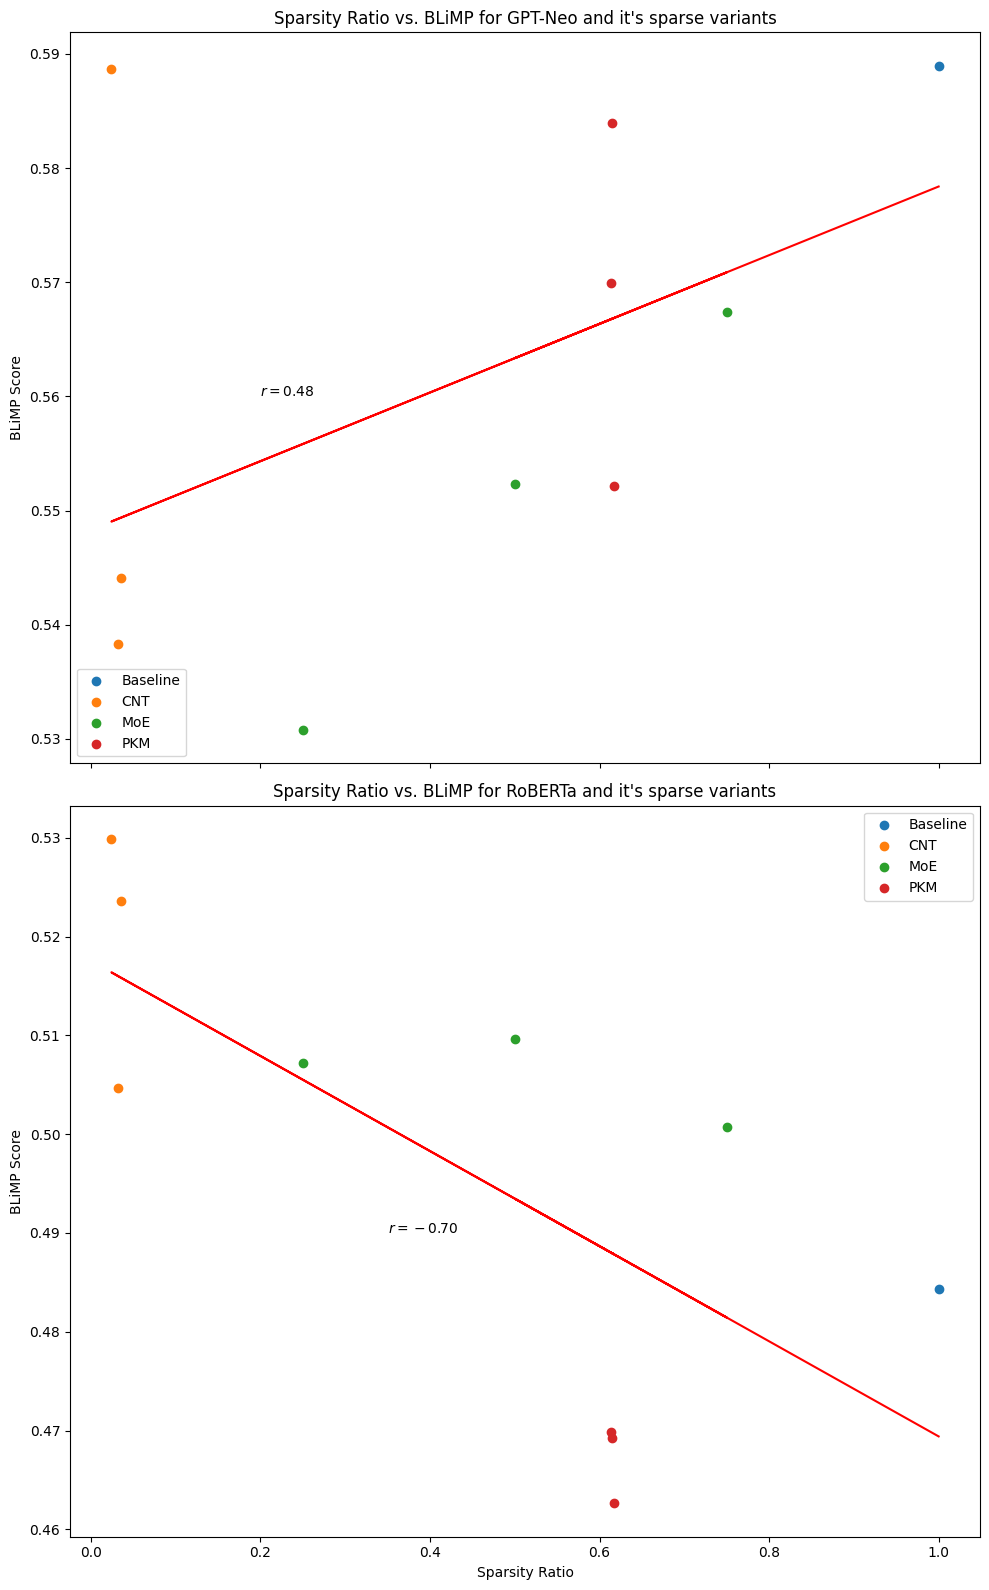

In [49]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16),sharex=True)

for group in np.unique(np.array([sparsity_type(col) for col in gpt_cols])): 
    ax1.scatter(gpt_blimp.loc['Sparsity Ratio'][np.array([sparsity_type(col) for col in gpt_cols]) == group], gpt_blimp.loc['Overall'][np.array([sparsity_type(col) for col in gpt_cols]) == group], label=group)
slope, intercept, r_value, p_value, std_err = linregress(gpt_blimp.loc['Sparsity Ratio'], gpt_blimp.loc['Overall'])
ax1.plot(gpt_blimp.loc['Sparsity Ratio'], slope * gpt_blimp.loc['Sparsity Ratio'] + intercept, color='red')
ax1.set_title("Sparsity Ratio vs. BLiMP for GPT-Neo and it's sparse variants")
#ax1.set_xlabel("Sparsity Ratio")
ax1.set_ylabel("BLiMP Score")
ax1.text(x=0.2, y = 0.56, s=f'$r={r_value:.2f}$')
ax1.legend()


for group in np.unique(np.array([sparsity_type(col) for col in roberta_cols])): 
    ax2.scatter(roberta_blimp.loc['Sparsity Ratio'][np.array([sparsity_type(col) for col in roberta_cols]) == group], roberta_blimp.loc['Overall'][np.array([sparsity_type(col) for col in roberta_cols]) == group], label=group)
slope, intercept, r_value, p_value, std_err = linregress(roberta_blimp.loc['Sparsity Ratio'], roberta_blimp.loc['Overall'])
ax2.plot(roberta_blimp.loc['Sparsity Ratio'], slope * roberta_blimp.loc['Sparsity Ratio'] + intercept, color='r')
ax2.set_title("Sparsity Ratio vs. BLiMP for RoBERTa and it's sparse variants")
ax2.text(x=0.35, y = 0.49, s=f'$r={r_value:.2f}$')
ax2.set_xlabel("Sparsity Ratio")
ax2.set_ylabel("BLiMP Score")
ax2.legend()

plt.tight_layout()
plt.show()


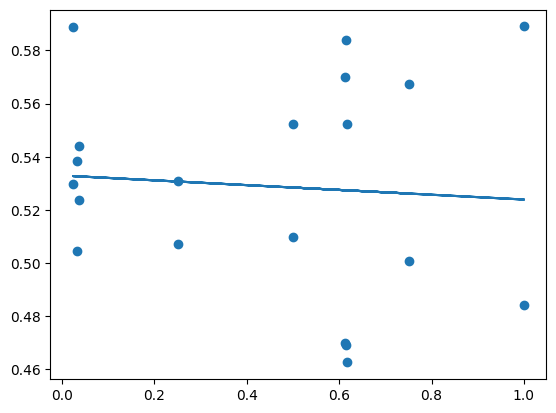

-0.07480196352009025


In [65]:
plt.scatter(blimp_scores.loc['Sparsity Ratio'], blimp_scores.loc['Overall'])
slope, intercept, r_value, p_value, std_err = linregress(blimp_scores.loc['Sparsity Ratio'], blimp_scores.loc['Overall'])
plt.plot(blimp_scores.loc['Sparsity Ratio'], slope * blimp_scores.loc['Sparsity Ratio'] + intercept)
plt.show()
print(r_value)

In [66]:
gpt_eval_loss = pd.read_csv('gpt_eval_loss.csv')
gpt_eval_loss = gpt_eval_loss.drop(columns=[col for col in gpt_eval_loss.columns if 'MIN' in col or 'MAX' in col])
for col in gpt_eval_loss.columns:
    if col != 'Step':
        print(col, sparsity_ratio(col))

gpt_pkm_high - eval/loss 0.6134803921568628
gpt_pkm_medium - eval/loss 0.6151960784313726
gpt_pkm_low - eval/loss 0.6169117647058824
gpt_cnt_high - eval/loss 0.03615438447027323
gpt_cnt_medium - eval/loss 0.024239934264585046
gpt_cnt_low - eval/loss 0.03181860022705655
gpt_moe_low - eval/loss 0.7502435464935965
gpt_moe_high - eval/loss 0.25073063948078933
gpt_moe_medium - eval/loss 0.5004870929871928
gpt_baseline - eval/loss 1.0


In [67]:
gpt_eval_loss = pd.read_csv('gpt_eval_loss.csv')
gpt_eval_loss = gpt_eval_loss.drop(columns=[col for col in gpt_eval_loss.columns if 'MIN' in col or 'MAX' in col])
gpt_eval_loss = gpt_eval_loss.rename(columns={col: name_conversion(col) for col in gpt_eval_loss.columns if col != 'Step'})
gpt_eval_loss

,Step,GPT-Neo PKM ($k=14$),GPT-Neo PKM ($k=28$),GPT-Neo PKM ($k=42$),GPT-Neo CNT ($N=16$),GPT-Neo CNT ($N=32$),GPT-Neo CNT ($N=64$),GPT-Neo MoE ($k=3$),GPT-Neo MoE ($k=1$),GPT-Neo MoE ($k=2$),GPT-Neo
0,2,2.936840,2.926169,2.949441,3.062659,3.012976,3.089170,2.605631,2.893417,2.595905,2.497805
1,4,2.437337,2.442173,2.435794,2.596858,2.562127,2.580930,2.179572,2.394802,2.168495,2.107658
2,6,2.241107,2.258385,2.241023,2.379031,2.343688,2.349521,2.000344,2.191069,1.995769,1.956240
3,8,2.144249,2.155936,2.133947,2.266796,2.225472,2.223340,1.898287,2.077069,1.889923,1.868954
4,10,2.075456,2.094606,2.082344,2.190787,2.151990,2.145256,1.829374,2.004117,1.828218,1.809228
5,12,2.032396,2.042756,2.025907,2.133039,2.098104,2.085228,1.782302,1.954407,1.779705,1.768884
6,14,1.999849,2.001808,1.987986,2.094704,2.060910,2.044462,1.746865,1.916523,1.747702,1.737035
7,16,1.973594,1.980298,1.970253,2.062346,2.028554,2.010948,1.718215,1.886994,1.721087,1.711763
8,18,1.954516,1.950917,1.941804,2.035494,2.003703,1.985014,1.695609,1.862404,1.697259,1.689958
9,20,1.939212,1.935175,1.922171,2.011276,1.983479,1.961584,1.676054,1.842870,1.678740,1.672484


In [90]:
roberta_eval_loss = pd.read_csv('roberta_eval_loss.csv')
roberta_eval_loss = roberta_eval_loss.drop(columns=[col for col in roberta_eval_loss.columns if 'MIN' in col or 'MAX' in col])
roberta_eval_loss = roberta_eval_loss.rename(columns={col: name_conversion(col) for col in roberta_eval_loss.columns if col != 'Step'})
roberta_eval_loss

,Step,RoBERTa PKM ($k=14$),RoBERTa PKM ($k=28$),RoBERTa PKM ($k=42$),RoBERTa CNT ($N=16$),RoBERTa CNT ($N=32$),RoBERTa CNT ($N=64$),RoBERTa MoE ($k=1$),RoBERTa MoE ($k=2$),RoBERTa MoE ($k=3$),RoBERTa
0,2,0.008501,0.008468,0.008464,0.008770,0.008418,0.008804,0.008513,0.007983,0.007673,0.005542
1,4,0.002718,0.002710,0.002707,0.002663,0.002621,0.002658,0.003312,0.003019,0.003700,0.001779
2,6,0.001352,0.001348,0.001347,0.001306,0.001298,0.001256,0.002135,0.001861,0.002426,0.000881
3,8,0.000806,0.000804,0.000803,0.000777,0.000771,0.000747,0.001678,0.001134,0.002591,0.000526
4,10,0.000532,0.000530,0.000529,0.000511,0.000509,0.000489,0.001471,0.000727,0.001417,0.000347
5,12,0.000381,0.000379,0.000379,0.000367,0.000362,0.000353,0.001374,0.000570,0.001478,0.000249
6,14,0.000286,0.000284,0.000284,0.000272,0.000268,0.000263,0.001438,0.000353,0.000966,0.000185
7,16,0.000221,0.000220,0.000220,0.000209,0.000206,0.000204,0.001454,0.000266,0.001755,0.000142
8,18,0.000173,0.000172,0.000172,0.000162,0.000160,0.000157,0.001486,0.000186,0.000779,0.000109
9,20,0.000142,0.000141,0.000141,0.000132,0.000130,0.000128,0.001558,0.000157,0.001032,0.000089


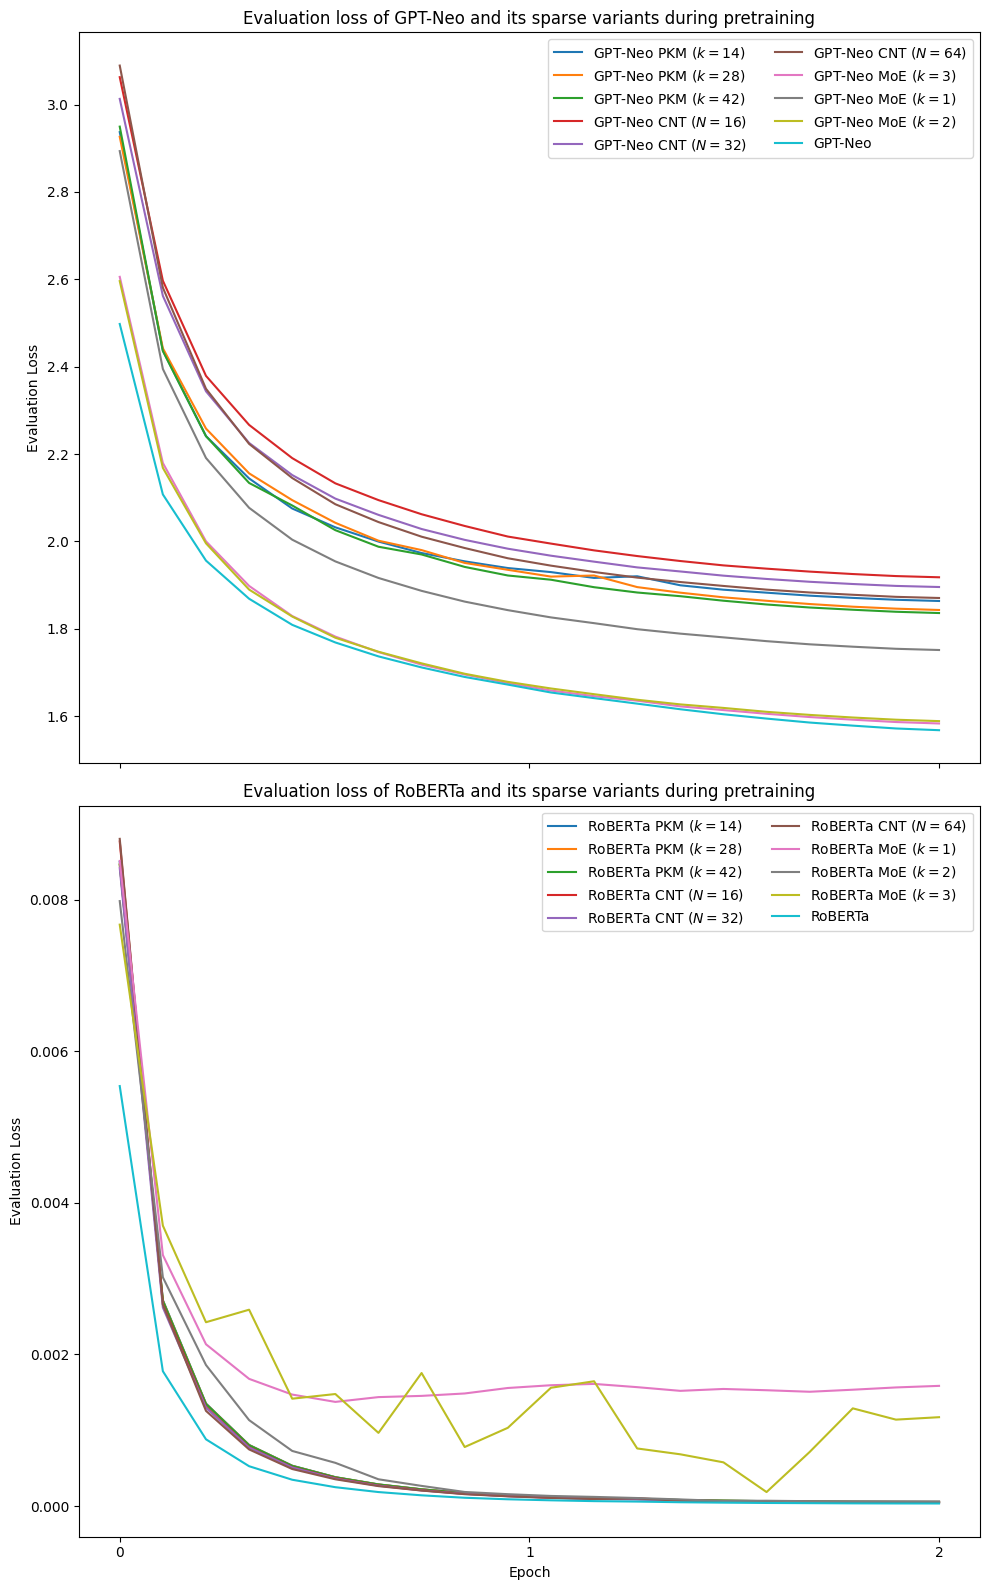

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16), sharex=True)

for column in gpt_eval_loss.columns:
    if column != 'Step':
        ax1.plot(np.linspace(0,2,num=20), gpt_eval_loss[column], label=column)
        
for column in roberta_eval_loss.columns:
    if column != 'Step':    
        ax2.plot(np.linspace(0,2,num=20), roberta_eval_loss[column], label=column)

ax2.set_xlabel('Epoch')
ax1.set_ylabel('Evaluation Loss')
ax2.set_ylabel('Evaluation Loss')
ax1.set_title('Evaluation loss of GPT-Neo and its sparse variants during pretraining')
ax2.set_title('Evaluation loss of RoBERTa and its sparse variants during pretraining')
ax1.legend(ncol=2)
ax2.legend(ncol=2)
ax1.set_xticks([0, 1, 2])
plt.tight_layout()
plt.show()

In [51]:
def superglue_results(name, path):
    tasks = ["cola", "sst2", "mrpc", "qqp", "mnli", "mnli-mm", "qnli", "rte", "boolq", "multirc", "wsc"]
    scores = {}
    for task in os.listdir(os.path.join(path, 'finetune')):
        if task in tasks:
            with open(os.path.join(path, 'finetune', task, 'all_results.json'), 'r') as f:
                result = json.load(f)
                avg = []
                if 'eval_accuracy' in result:
                    avg.append(result["eval_accuracy"])
                if 'eval_f1' in result:
                    avg.append(result["eval_f1"])
                if 'eval_mcc' in result:
                    avg.append(result["eval_mcc"])
                scores[task] = np.mean(avg)
    overall = np.mean(list(scores.values()))
    scores['Overall'] = overall
    scores['Name'] = name
    scores = {k: [v] for k, v in scores.items()}
    df = pd.DataFrame(scores, index=[0])
    return df

In [52]:
def superglue_results_all(path):
    dfs = []
    for subdir in os.listdir(path):
        dfs.append(superglue_results(name_conversion(subdir), os.path.join(path, subdir)))
    return pd.concat(dfs, ignore_index=True)

In [53]:
all_superglue = superglue_results_all('../../models/superglue')
all_superglue = all_superglue[['Name', 'Overall'] + all_superglue.columns.tolist()[:-2]]
all_superglue

,Name,Overall,boolq,cola,mnli,mnli-mm,mrpc,multirc,qnli,qqp,rte,sst2,wsc
0,GPT-Neo,0.502948,0.510192,0.503871,0.644011,0.646722,0.466177,0.329033,0.478357,0.687916,0.296631,0.763312,0.206210
1,GPT-Neo CNT ($N=16$),0.487438,0.470990,0.524521,0.620543,0.633514,0.476366,0.321799,0.464948,0.663673,0.281313,0.728676,0.175473
2,GPT-Neo CNT ($N=64$),0.496097,0.489269,0.545922,0.625419,0.631604,0.476071,0.315570,0.474413,0.665796,0.340102,0.739725,0.153180
3,GPT-Neo CNT ($N=32$),0.506327,0.500236,0.506662,0.620390,0.642425,0.527016,0.314338,0.482113,0.664502,0.370330,0.749814,0.191771
4,GPT-Neo MoE ($k=1$),0.515108,0.478748,0.520036,0.632429,0.631604,0.490263,0.318545,0.481664,0.621664,0.399376,0.754819,0.337044
5,GPT-Neo MoE ($k=3$),0.502848,0.497341,0.510152,0.645078,0.653565,0.395372,0.295982,0.599561,0.692846,0.289972,0.768572,0.182884
6,GPT-Neo MoE ($k=2$),0.510420,0.488143,0.488193,0.644011,0.654360,0.508679,0.352163,0.479161,0.681659,0.343509,0.730796,0.243948
7,GPT-Neo PKM ($k=14$),0.514039,0.490095,0.527020,0.643249,0.645926,0.482832,0.352527,0.482812,0.696450,0.423581,0.770826,0.139114
8,GPT-Neo PKM ($k=42$),0.514008,0.513715,0.500658,0.630448,0.630172,0.523850,0.337570,0.468020,0.664617,0.352865,0.748883,0.283294
9,GPT-Neo PKM ($k=28$),0.507974,0.504084,0.527150,0.629991,0.637333,0.485826,0.329840,0.476592,0.660069,0.340881,0.732003,0.263944


In [54]:
print(all_superglue.to_latex(index=False,float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Name & Overall & boolq & cola & mnli & mnli-mm & mrpc & multirc & qnli & qqp & rte & sst2 & wsc \\
\midrule
GPT-Neo & 0.503 & 0.510 & 0.504 & 0.644 & 0.647 & 0.466 & 0.329 & 0.478 & 0.688 & 0.297 & 0.763 & 0.206 \\
GPT-Neo CNT ($N=16$) & 0.487 & 0.471 & 0.525 & 0.621 & 0.634 & 0.476 & 0.322 & 0.465 & 0.664 & 0.281 & 0.729 & 0.175 \\
GPT-Neo CNT ($N=64$) & 0.496 & 0.489 & 0.546 & 0.625 & 0.632 & 0.476 & 0.316 & 0.474 & 0.666 & 0.340 & 0.740 & 0.153 \\
GPT-Neo CNT ($N=32$) & 0.506 & 0.500 & 0.507 & 0.620 & 0.642 & 0.527 & 0.314 & 0.482 & 0.665 & 0.370 & 0.750 & 0.192 \\
GPT-Neo MoE ($k=1$) & 0.515 & 0.479 & 0.520 & 0.632 & 0.632 & 0.490 & 0.319 & 0.482 & 0.622 & 0.399 & 0.755 & 0.337 \\
GPT-Neo MoE ($k=3$) & 0.503 & 0.497 & 0.510 & 0.645 & 0.654 & 0.395 & 0.296 & 0.600 & 0.693 & 0.290 & 0.769 & 0.183 \\
GPT-Neo MoE ($k=2$) & 0.510 & 0.488 & 0.488 & 0.644 & 0.654 & 0.509 & 0.352 & 0.479 & 0.682 & 0.344 & 0.731 & 0.244 \\
GPT-Neo PKM ($k=14$) & 0.514

In [55]:
print(all_superglue[['Name', 'Overall']].to_latex(index=False,float_format="%.3f"))

\begin{tabular}{lr}
\toprule
Name & Overall \\
\midrule
GPT-Neo & 0.503 \\
GPT-Neo CNT ($N=16$) & 0.487 \\
GPT-Neo CNT ($N=64$) & 0.496 \\
GPT-Neo CNT ($N=32$) & 0.506 \\
GPT-Neo MoE ($k=1$) & 0.515 \\
GPT-Neo MoE ($k=3$) & 0.503 \\
GPT-Neo MoE ($k=2$) & 0.510 \\
GPT-Neo PKM ($k=14$) & 0.514 \\
GPT-Neo PKM ($k=42$) & 0.514 \\
GPT-Neo PKM ($k=28$) & 0.508 \\
RoBERTa & 0.446 \\
RoBERTa CNT ($N=16$) & 0.456 \\
RoBERTa CNT ($N=64$) & 0.444 \\
RoBERTa CNT ($N=32$) & 0.440 \\
RoBERTa MoE ($k=1$) & 0.458 \\
RoBERTa MoE ($k=3$) & 0.472 \\
RoBERTa MoE ($k=2$) & 0.467 \\
RoBERTa PKM ($k=14$) & 0.468 \\
RoBERTa PKM ($k=42$) & 0.465 \\
RoBERTa PKM ($k=28$) & 0.469 \\
\bottomrule
\end{tabular}



In [56]:

blimp = blimp_results_all('../../models/sparse_pretrained/')[['Name','Overall']].rename(columns={'Overall': 'BLiMP'})
superglue = all_superglue[['Name','Overall']].rename(columns={'Overall': 'SuperGLUE'})

# Merging the dataframes on the Name column
summary = pd.merge(blimp, superglue, on='Name')

summary

,Name,BLiMP,SuperGLUE
0,GPT-Neo,0.588985,0.502948
1,GPT-Neo CNT ($N=16$),0.544106,0.487438
2,GPT-Neo CNT ($N=64$),0.538353,0.496097
3,GPT-Neo CNT ($N=32$),0.588685,0.506327
4,GPT-Neo MoE ($k=1$),0.530768,0.515108
5,GPT-Neo MoE ($k=3$),0.567430,0.502848
6,GPT-Neo MoE ($k=2$),0.552355,0.510420
7,GPT-Neo PKM ($k=14$),0.569912,0.514039
8,GPT-Neo PKM ($k=42$),0.552149,0.514008
9,GPT-Neo PKM ($k=28$),0.583929,0.507974


In [57]:
print(summary.to_latex(index=False,float_format="%.3f"))

\begin{tabular}{lrr}
\toprule
Name & BLiMP & SuperGLUE \\
\midrule
GPT-Neo & 0.589 & 0.503 \\
GPT-Neo CNT ($N=16$) & 0.544 & 0.487 \\
GPT-Neo CNT ($N=64$) & 0.538 & 0.496 \\
GPT-Neo CNT ($N=32$) & 0.589 & 0.506 \\
GPT-Neo MoE ($k=1$) & 0.531 & 0.515 \\
GPT-Neo MoE ($k=3$) & 0.567 & 0.503 \\
GPT-Neo MoE ($k=2$) & 0.552 & 0.510 \\
GPT-Neo PKM ($k=14$) & 0.570 & 0.514 \\
GPT-Neo PKM ($k=42$) & 0.552 & 0.514 \\
GPT-Neo PKM ($k=28$) & 0.584 & 0.508 \\
RoBERTa & 0.484 & 0.446 \\
RoBERTa CNT ($N=16$) & 0.524 & 0.456 \\
RoBERTa CNT ($N=64$) & 0.505 & 0.444 \\
RoBERTa CNT ($N=32$) & 0.530 & 0.440 \\
RoBERTa MoE ($k=1$) & 0.507 & 0.458 \\
RoBERTa MoE ($k=3$) & 0.501 & 0.472 \\
RoBERTa MoE ($k=2$) & 0.510 & 0.467 \\
RoBERTa PKM ($k=14$) & 0.470 & 0.468 \\
RoBERTa PKM ($k=42$) & 0.463 & 0.465 \\
RoBERTa PKM ($k=28$) & 0.469 & 0.469 \\
\bottomrule
\end{tabular}



In [58]:
superglue_scores = all_superglue[['Name','Overall']]
superglue_scores = superglue_scores.set_index('Name').T
superglue_scores.loc['Sparsity Ratio'] = sr
superglue_scores

Name,GPT-Neo,GPT-Neo CNT ($N=16$),GPT-Neo CNT ($N=64$),GPT-Neo CNT ($N=32$),GPT-Neo MoE ($k=1$),GPT-Neo MoE ($k=3$),GPT-Neo MoE ($k=2$),GPT-Neo PKM ($k=14$),GPT-Neo PKM ($k=42$),GPT-Neo PKM ($k=28$),RoBERTa,RoBERTa CNT ($N=16$),RoBERTa CNT ($N=64$),RoBERTa CNT ($N=32$),RoBERTa MoE ($k=1$),RoBERTa MoE ($k=3$),RoBERTa MoE ($k=2$),RoBERTa PKM ($k=14$),RoBERTa PKM ($k=42$),RoBERTa PKM ($k=28$)
Overall,0.502948,0.487438,0.496097,0.506327,0.515108,0.502848,0.510420,0.514039,0.514008,0.507974,0.445684,0.455913,0.444274,0.43970,0.458396,0.471792,0.467490,0.468422,0.464772,0.469048
Sparsity Ratio,1.000000,0.036154,0.031819,0.024240,0.250731,0.750244,0.500487,0.613480,0.616912,0.615196,1.000000,0.036154,0.031819,0.02424,0.250731,0.750244,0.500487,0.613480,0.616912,0.615196


In [59]:
gpt_cols = superglue_scores.columns[superglue_scores.columns.to_series().apply(lambda x: 'GPT' in x )]
gpt_superglue = superglue_scores[gpt_cols]
roberta_cols = superglue_scores.columns[superglue_scores.columns.to_series().apply(lambda x: 'RoBERTa' in x )]
roberta_superglue = superglue_scores[roberta_cols]

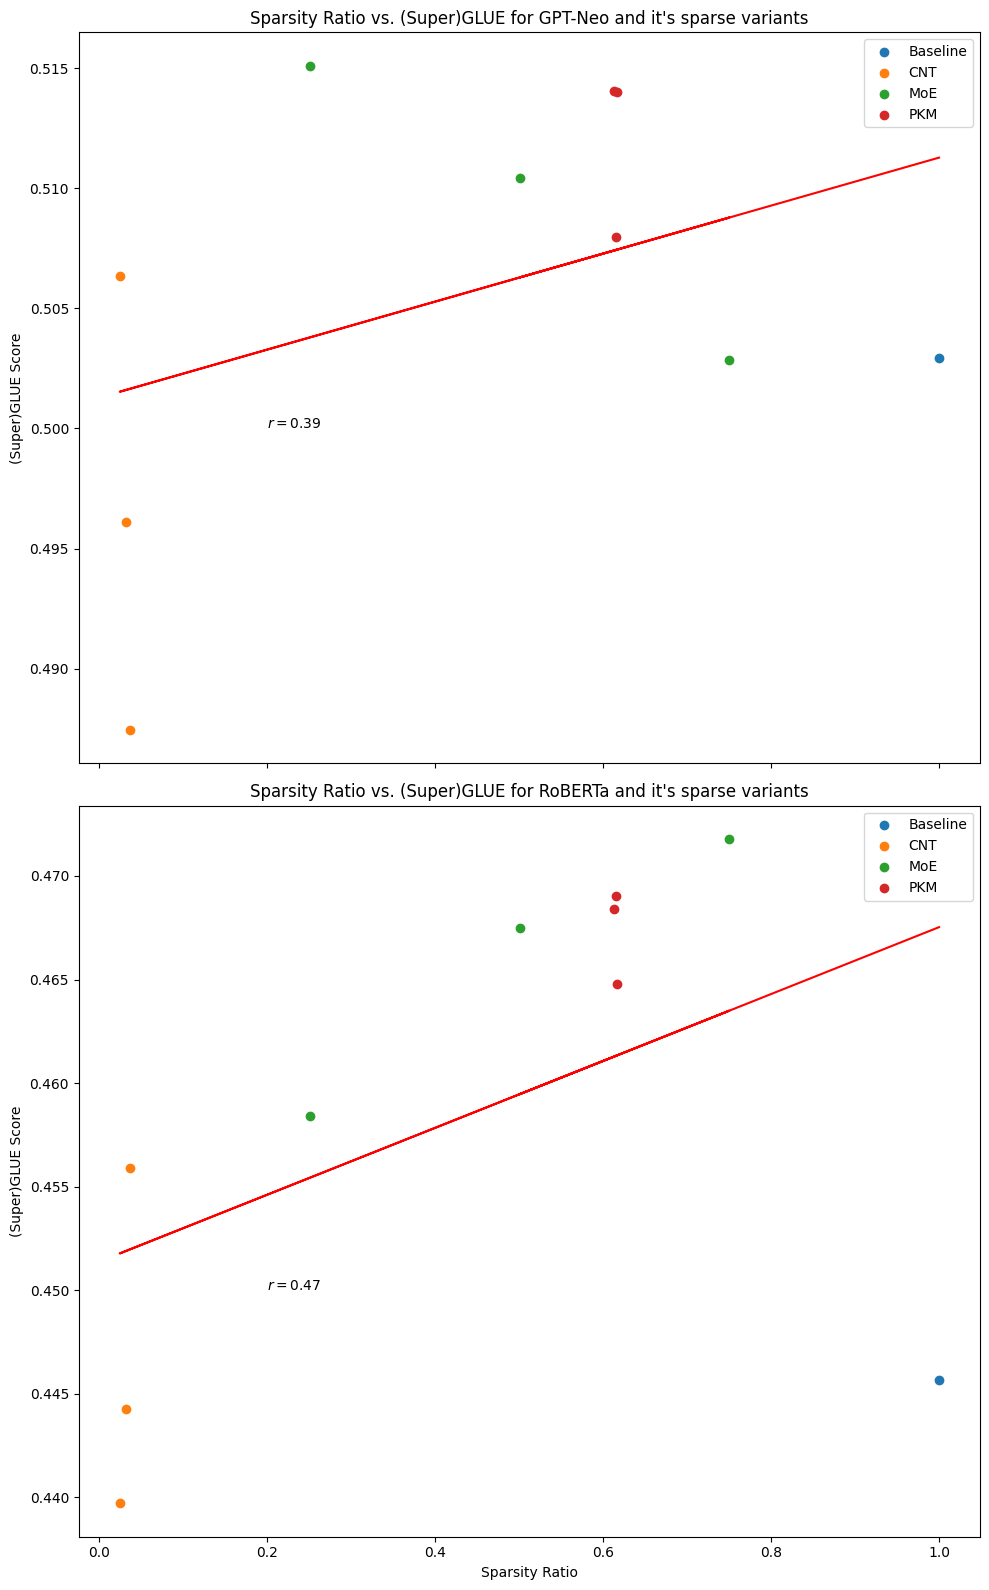

In [62]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16), sharex=True)

for group in np.unique(np.array([sparsity_type(col) for col in gpt_cols])): 
    ax1.scatter(gpt_superglue.loc['Sparsity Ratio'][np.array([sparsity_type(col) for col in gpt_cols]) == group], gpt_superglue.loc['Overall'][np.array([sparsity_type(col) for col in gpt_cols]) == group], label=group)
slope, intercept, r_value, p_value, std_err = linregress(gpt_superglue.loc['Sparsity Ratio'], gpt_superglue.loc['Overall'])
ax1.plot(gpt_superglue.loc['Sparsity Ratio'], slope * gpt_superglue.loc['Sparsity Ratio'] + intercept, color='red')
ax1.set_title("Sparsity Ratio vs. (Super)GLUE for GPT-Neo and it's sparse variants")
#ax1.set_xlabel("Sparsity Ratio")
ax1.set_ylabel("(Super)GLUE Score")
ax1.text(x=0.2, y = 0.5, s=f'$r={r_value:.2f}$')
ax1.legend()


for group in np.unique(np.array([sparsity_type(col) for col in roberta_cols])): 
    ax2.scatter(roberta_superglue.loc['Sparsity Ratio'][np.array([sparsity_type(col) for col in roberta_cols]) == group], roberta_superglue.loc['Overall'][np.array([sparsity_type(col) for col in roberta_cols]) == group], label=group)
slope, intercept, r_value, p_value, std_err = linregress(roberta_superglue.loc['Sparsity Ratio'], roberta_superglue.loc['Overall'])
ax2.plot(roberta_superglue.loc['Sparsity Ratio'], slope * roberta_superglue.loc['Sparsity Ratio'] + intercept, color='r')
ax2.set_title("Sparsity Ratio vs. (Super)GLUE for RoBERTa and it's sparse variants")
ax2.text(x=0.2, y = 0.45, s=f'$r={r_value:.2f}$')
ax2.set_xlabel("Sparsity Ratio")
ax2.set_ylabel("(Super)GLUE Score")
ax2.legend()

plt.tight_layout()
plt.show()


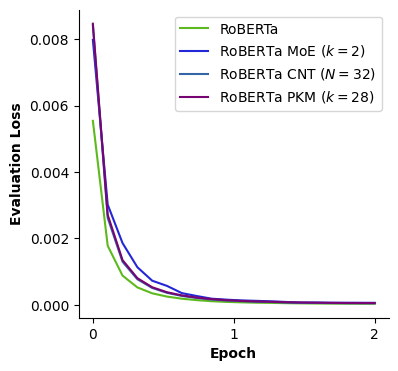

In [181]:
plt.figure(figsize=(4, 4))
plt.plot(np.linspace(0,2,num=20), roberta_eval_loss['RoBERTa'], label='RoBERTa', color= '#5eb91e')
plt.plot(np.linspace(0,2,num=20), roberta_eval_loss['RoBERTa MoE ($k=2$)'], label='RoBERTa MoE ($k=2$)', color='#2327d6')
plt.plot(np.linspace(0,2,num=20), roberta_eval_loss['RoBERTa CNT ($N=32$)'], label='RoBERTa CNT ($N=32$)', color='#3465a4')
plt.plot(np.linspace(0,2,num=20), roberta_eval_loss['RoBERTa PKM ($k=28$)'], label='RoBERTa PKM ($k=28$)', color='#780373')

plt.xlabel('Epoch', weight='bold')
plt.ylabel('Evaluation Loss', weight='bold')
plt.legend()
plt.xticks([0, 1, 2])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('eval_loss.png', transparent=True, bbox_inches = 'tight')
plt.show()

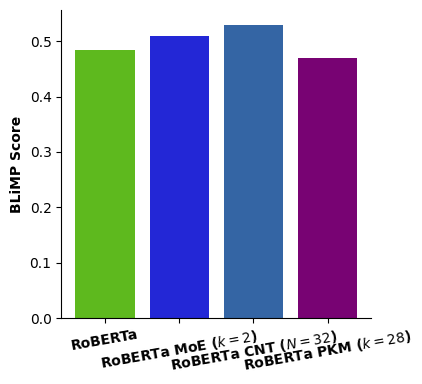

In [180]:
display_order = ['RoBERTa',
                 'RoBERTa MoE ($k=2$)',
                 'RoBERTa CNT ($N=32$)',
                 'RoBERTa PKM ($k=28$)',
                ]
colors = [ '#5eb91e',
          '#2327d6',
          '#3465a4',
          '#780373',
    ]

plt.figure(figsize=(4, 4))
plt.bar(np.arange(len(display_order)), blimp_scores.loc['Overall'][display_order], tick_label = display_order, color = colors)
plt.xticks( weight='bold')
plt.ylabel('BLiMP Score', weight='bold')

plt.xticks(rotation=10, weight='bold')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.savefig('blimp scores.png', transparent=True, bbox_inches = 'tight')
plt.show()


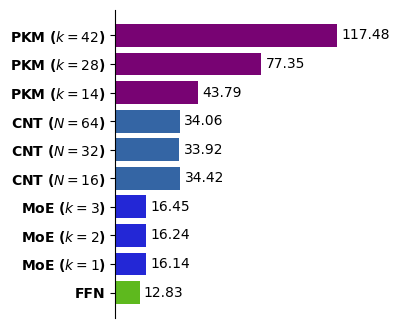

In [21]:
display_order = ['FFN',
                 'MoE ($k=1$)', 'MoE ($k=2$)', 'MoE ($k=3$)', 
                 'CNT ($N=16$)', 'CNT ($N=32$)', 'CNT ($N=64$)',
                 'PKM ($k=14$)', 'PKM ($k=28$)', 'PKM ($k=42$)',
                ]
colors = [ '#5eb91e',
          '#2327d6','#2327d6','#2327d6',
          '#3465a4', '#3465a4', '#3465a4', 
          '#780373','#780373','#780373',
    ]

times = [12.83, 16.14, 16.24, 16.45, 34.42, 33.92, 34.06, 43.79, 77.35, 117.48]

plt.figure(figsize=(3, 4))
bars = plt.barh(np.arange(len(times)), times, tick_label=display_order, color=colors)

# Add labels on top of the bars
plt.bar_label(bars, labels=[str(time) for time in times], padding=3)

plt.yticks(weight='bold')
#plt.ylabel('Inference Time (ms)', weight='bold')

# Remove the top and right borders
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_visible(False)

# Save the plot
plt.savefig('inference_times.png', transparent=True, bbox_inches='tight')
plt.show()

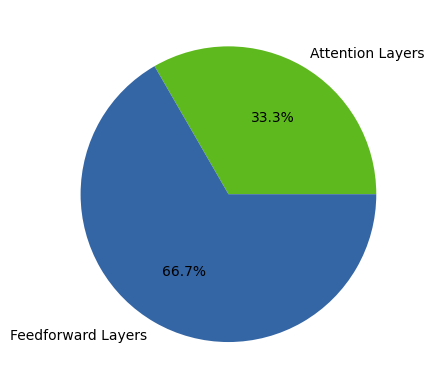

In [16]:
labels = 'Attention Layers', 'Feedforward Layers'
sizes = np.array([1/3,2/3])
colors = ['#5eb91e','#3465a4']

def percentage(val):
    return f'{val:.1f}%'

plt.pie(sizes, labels=labels, colors=colors,
        autopct=percentage)

#plt.axis('equal')

plt.savefig('param_dist.png', transparent=True, bbox_inches='tight')
plt.show()

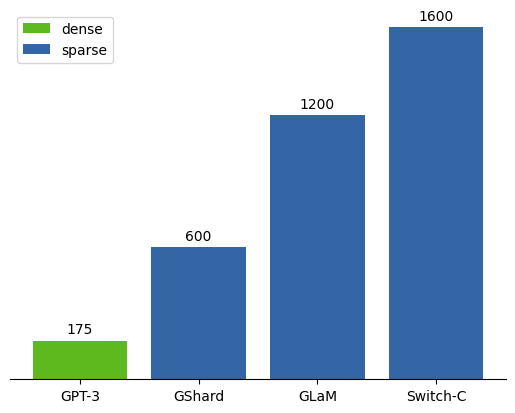

In [29]:
display_order = ['GPT-3', 'GShard', 'GLaM', 'Switch-C']
colors = [ '#5eb91e',
          '#3465a4',
          '#3465a4',
          '#3465a4'
    ]

sizes = [175, 600, 1200, 1600]

#plt.figure(figsize=(3, 4))
bars = plt.bar(np.arange(len(sizes)), sizes, tick_label=display_order, color=colors)

# Add labels on top of the bars
plt.bar_label(bars, labels=[str(s) for s in sizes], padding=3)

plt.yticks(weight='bold')
#plt.ylabel('Inference Time (ms)', weight='bold')

# Remove the top and right borders
ax = plt.gca()

ax.bar(0, 0,width=0,color='#5eb91e',label='dense') #Plot invisible bar graph but have the legends specified
ax.bar(0, 0,width=0,color='#3465a4',label='sparse')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.yaxis.set_visible(False)
plt.legend()
# Save the plot
plt.savefig('sparse_transformers.png', transparent=True, bbox_inches='tight')
plt.show()